# Notebook to compare the SWOT discharge error with SWOT height width and slope error for one reach

Look at many aspects of SWOT data and gage discharge
1. Timeseries of Q, and Q error
2. Scatterplots: look for correlations of Q error with other timeseries
3. Observation data quality exploration: look for correlation e.g. between SWOT data and gage discharge
4. Summaries of Qerror: histograms and statistics
5. If running in cal-val mode, explore SWOT observation error at cal-val sites
6. Look at parameters, calibrated resistance term, and try do error propagation
7. Correlate error levels with quality flags

In [1]:
import os
from pathlib import Path
import pandas as pd
from datetime import date, datetime
import numpy as np
from scipy import stats
import plotly.express as px

In [2]:
os.getcwd()

'/Users/mtd/Analysis/SWOT/Discharge/DirectCalibrationGageSWOT'

## 0. Read in data

In [3]:
DataDir=Path('ExperimentData/exps2/exp2-9/')
TimeseriesDir=DataDir.joinpath('gage+SWOT+cal')
FitDir=DataDir.joinpath('fit+stats')

In [4]:
# get timeseries files
tsfiles=os.listdir(TimeseriesDir)
tsfiles=[file for file in tsfiles if file[0]!='.']
tsfiles.sort()
# tsfiles

In [73]:
reachids=[file.split('_')[0] for file in tsfiles]
fidx=reachids.index('74270400051')

In [74]:
# show index and file
pd.DataFrame(data=tsfiles)

,0
0,71226500221_SWOT_gage_cal.csv
1,72554000101_SWOT_gage_cal.csv
2,72554000141_SWOT_gage_cal.csv
3,72554000161_SWOT_gage_cal.csv
4,72556000111_SWOT_gage_cal.csv
...,...
358,81250100101_SWOT_gage_cal.csv
359,81270501241_SWOT_gage_cal.csv
360,81320300021_SWOT_gage_cal.csv
361,81380500041_SWOT_gage_cal.csv


In [75]:
# fidx=86
reachid=tsfiles[fidx].split('_')[0]
reachid

'74270400051'

In [76]:
# fit files should be indexed same after sorting
fitfiles=os.listdir(FitDir)
fitfiles = [file for file in fitfiles if file[0]!='.']
fitfiles.sort()
# fitfiles

In [77]:
# SWOT data, SWOT discharge estimate and true discharge dataframe
fname=TimeseriesDir.joinpath(tsfiles[fidx])
df=pd.read_csv(fname)

# df=df.sort_values(by='time')

df['slope']*=1e5
df['εQ']=(df['Qhat']-df['Qgage'])/df['Qgage']

In [78]:
df.head()

,Unnamed: 0.1,Unnamed: 0,cycle_id,pass_id,time_str,wse,width,slope2,slope,reach_q,...,dark_frac_units,obs_frac_n_units,Qgage,bad-thresh,bad-bitwise,bad-thresh-or-bit,tukey-outlier,bad,Qhat,εQ
0,2,2,2.0,494.0,2023-08-28T17:16:40Z,103.9328,13.887842,0.000076,7.568891,2.0,...,1,1,52.040071,False,False,False,False,False,38.733930,-0.255690
1,4,4,3.0,216.0,2023-09-08T15:39:29Z,102.4302,5.819464,0.000076,7.568891,2.0,...,1,1,7.378049,False,False,False,False,False,24.511056,2.322160
2,14,14,5.0,494.0,2023-10-30T07:31:53Z,102.5387,13.311753,0.000076,7.568891,2.0,...,1,1,9.857189,False,False,False,False,False,31.657057,2.211571
3,15,15,5.0,509.0,2023-10-30T20:45:48Z,102.3258,31.606913,0.000076,7.568891,1.0,...,1,1,11.908933,False,False,False,False,False,37.535618,2.151888
4,35,35,11.0,216.0,2024-02-22T13:40:08Z,102.7640,8.533266,0.000076,7.568891,2.0,...,1,1,12.432858,False,False,False,False,False,29.577371,1.378968


In [79]:
# # cassie's comments
# dfc=pd.read_csv('algo5_indicators_mike_test_DarcyW_cs_20250214.csv')
# dfc[dfc['reach_id']==int(reachid)]['Cassie notes'].values[0]

In [80]:
dfps=pd.read_csv(FitDir.joinpath(fitfiles[fidx]),index_col=0)
dfps

,na,A0,x1,RMSE,rRMSE,nRMSE,NSE,VE,bias,stdresid,...,meanLogRes,stdLogRes,meanRelRes,stdRelRes,r,KGE,anr67,nMAE,Qbart,n
74270400051,0.008704,58.834035,0.955842,27.493521,1.671406,1.021118,0.424247,0.343449,1.949655,27.424306,...,0.308699,0.791967,0.848255,1.44016,0.65645,0.42394,1.409885,0.656551,26.924924,13.0


In [81]:
# read flag descriptions
flag_data=pd.read_excel('/Users/mtd/Documentses/Projects/SWOT/ADT/Filtering/reach_q_bitwise.xlsx')

In [82]:
def check_classification(q,flag_data):
    # print out which flags are set for a given code
    for index,row in flag_data.iterrows():
        if np.bitwise_and(row['flag_masks'],q):
            print('    data point has',row['flag_meanings'],'set to True')

## 1. Hydrographs: timeseries of Q and Q error

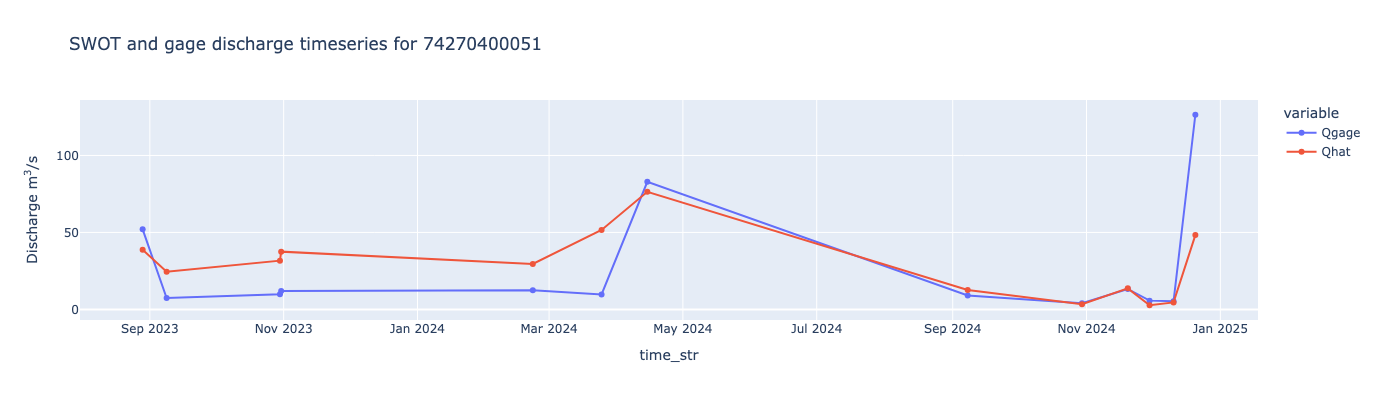

In [85]:
fig = px.line(df, x='time_str', y=df[['Qgage','Qhat']].columns,
              labels={"value": "Discharge m<sup>3</sup>/s"},
              markers=True,
              title='SWOT and gage discharge timeseries for '+reachid,
              height=400,width=800
             )
fig.show()

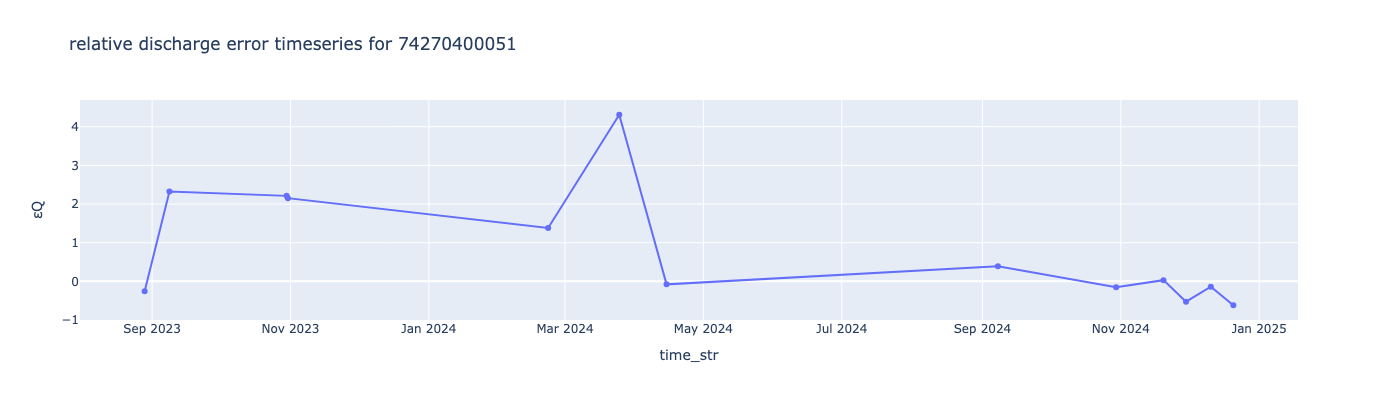

In [86]:
fig = px.line(df, x='time_str', y='εQ',markers=True,title='relative discharge error timeseries for '+reachid,
             height=400,width=800)
fig.show()

## 2. Scatterplots looking for correlations between discharge error and other timeseries

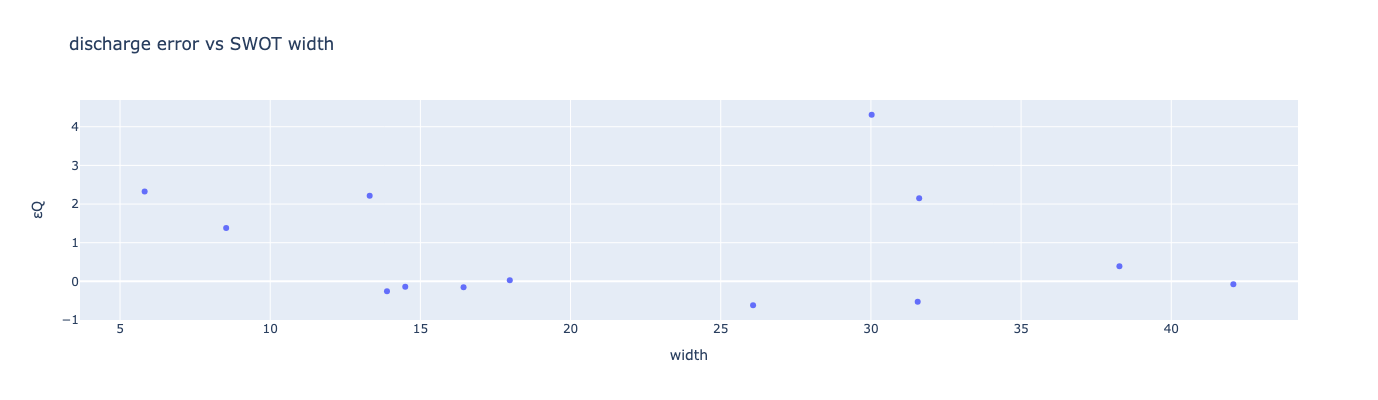

In [87]:
fig = px.scatter(df, x='width', y='εQ',title='discharge error vs SWOT width',height=400,width=800)
fig.show()

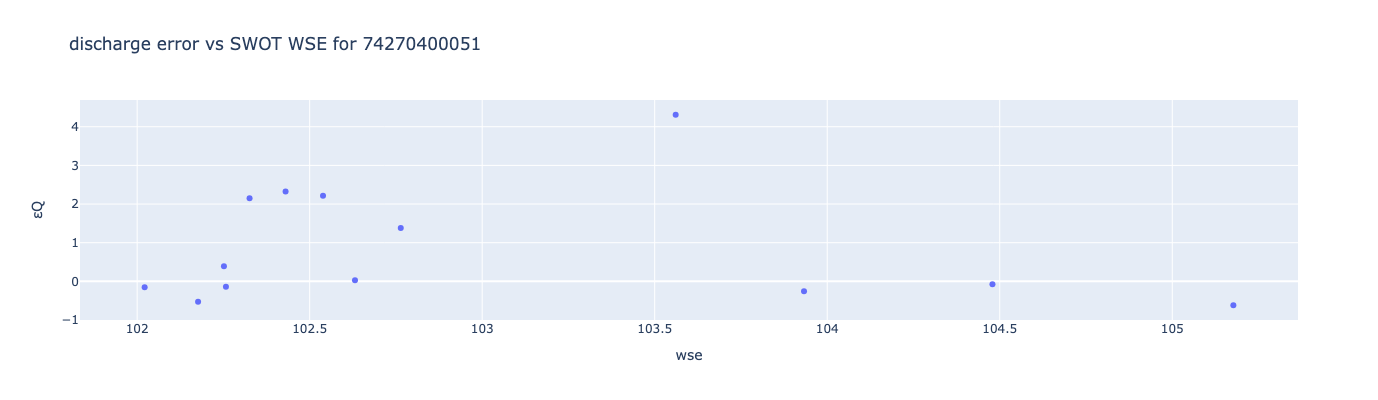

In [88]:
fig = px.scatter(df, x='wse', y='εQ',title='discharge error vs SWOT WSE for '+reachid,height=400,width=800)
fig.show()

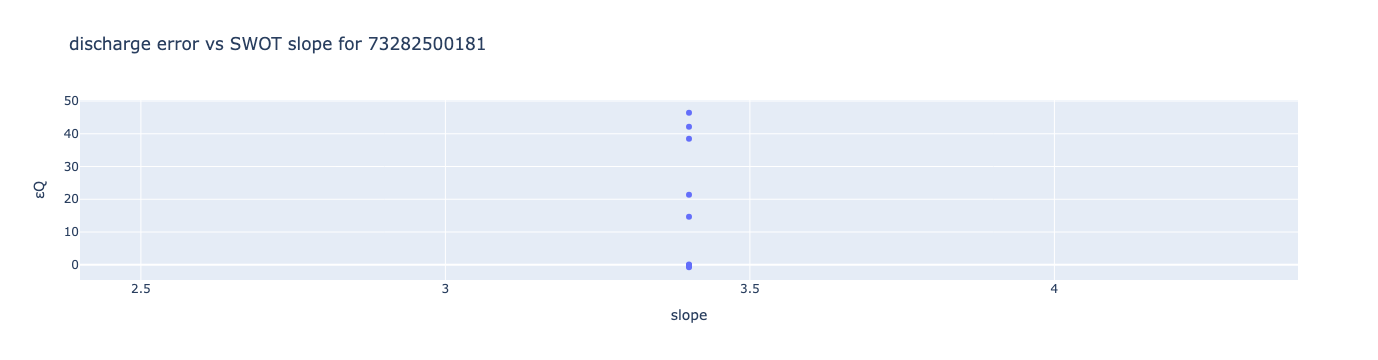

In [25]:
fig = px.scatter(df, x='slope', y='εQ',title='discharge error vs SWOT slope for '+reachid)
fig.show()

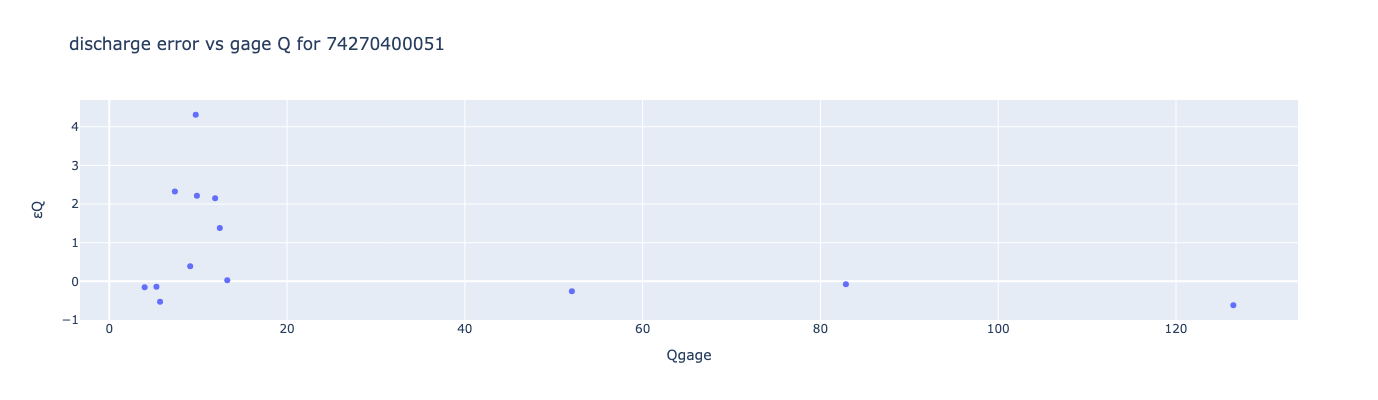

In [89]:
fig = px.scatter(df, x='Qgage', y='εQ',title='discharge error vs gage Q for '+reachid,height=400,width=800)
fig.show()

## 3. Data quality: look at scatters of SWOT data vs gage Q, and other metrics

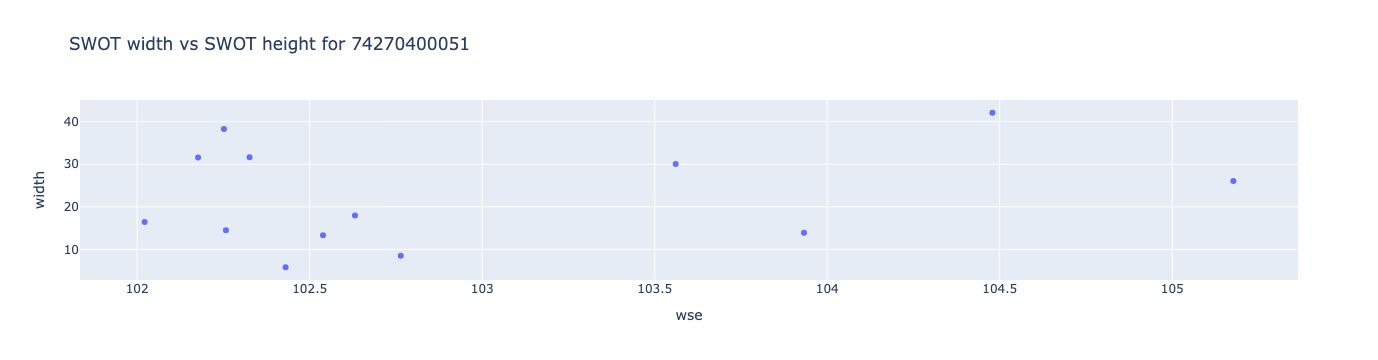

In [90]:
fig = px.scatter(df, x='wse', y='width',title='SWOT width vs SWOT height for '+reachid)
fig.show()

In [91]:
np.corrcoef(df['wse'],df['width'])

array([[1.        , 0.27237993],
       [0.27237993, 1.        ]])

In [92]:
stats.spearmanr(df['wse'],df['width'])

SignificanceResult(statistic=-0.027472527472527472, pvalue=0.929011729160351)

In [93]:
print('measured width standard deviation is ', np.std(df['width']),' m, compared with average of:' , np.mean(df['width']))

measured width standard deviation is  11.159026884618534  m, compared with average of: 22.313061


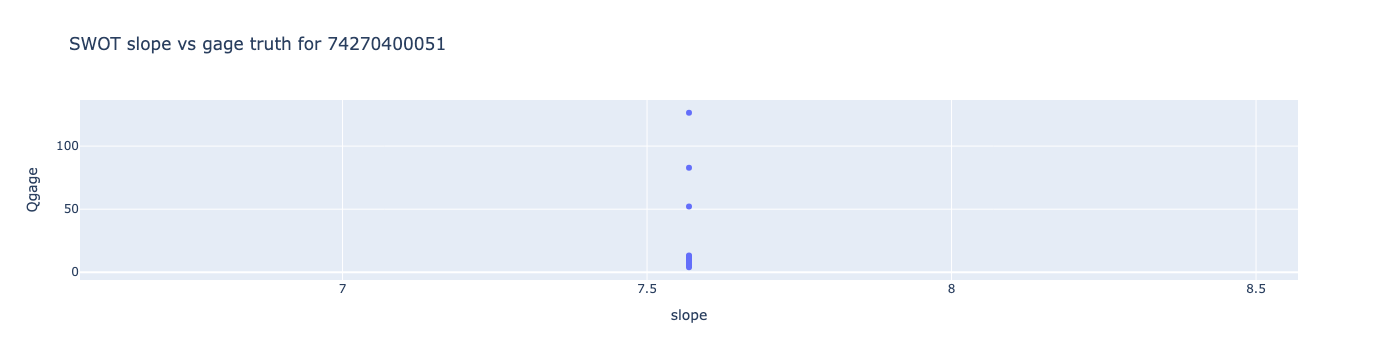

In [94]:
fig = px.scatter(df, x='slope', y='Qgage',title='SWOT slope vs gage truth for '+reachid)
fig.show()

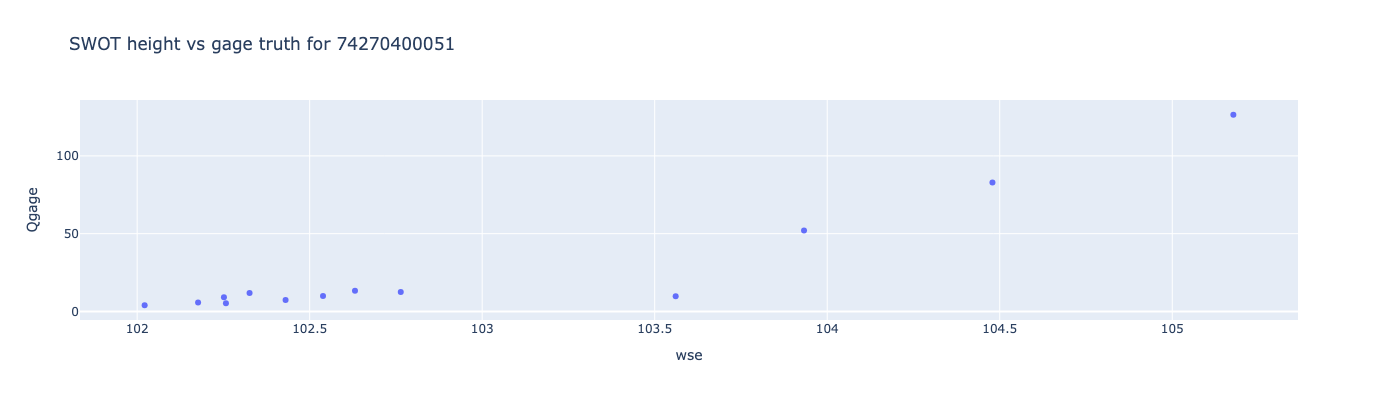

In [97]:
fig = px.scatter(df, x='wse', y='Qgage',title='SWOT height vs gage truth for '+reachid,height=400,width=800)
fig.show()

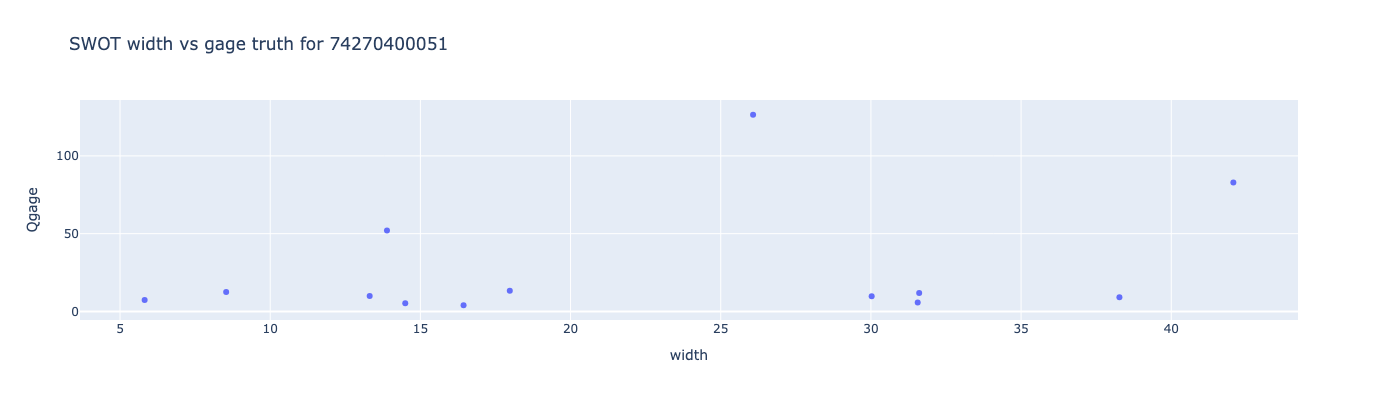

In [99]:
fig = px.scatter(df, x='width', y='Qgage',title='SWOT width vs gage truth for '+reachid,height=400,width=800)
fig.show()

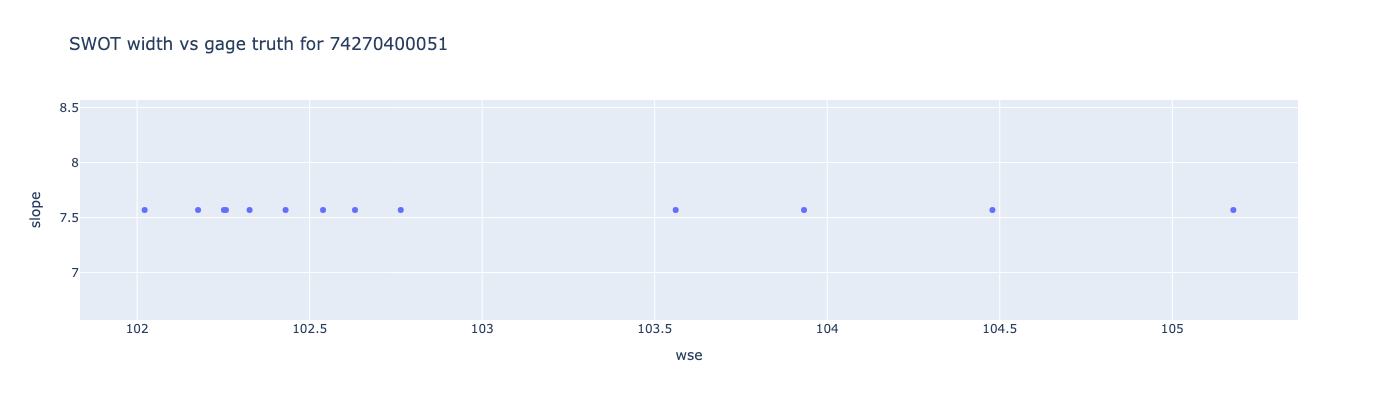

In [100]:
fig = px.scatter(df, x='wse', y='slope',title='SWOT width vs gage truth for '+reachid,height=400,width=800)
fig.show()

## 4. Summary of discharge error

In [101]:
print('67th percentile of discharge error',np.quantile(np.abs(df['εQ']),.67))
print('spearman correlation between gage and SWOT discharge',stats.spearmanr(df['Qgage'],df['Qhat']))
print('pearson correlation between gage and SWOT discharge',np.corrcoef(df['Qgage'],df['Qhat'])[0,1])
print('nbias',(np.mean(df['Qgage']-df['Qhat']))/np.mean(df['Qgage']))
# print('σε',(np.std( (df['Qgage']-df['Qhat'])/df['Qgage']) ) ) 
print('σε',(np.std( df['εQ']  ) ) ) 
print('nRMSE',np.sqrt(np.mean( (df['Qgage']-df['Qhat'])**2 ))/np.mean(df['Qgage']))
print('NSE',1-np.sum( (df['Qhat']-df['Qgage'])**2  )/np.sum( (df['Qgage']-np.mean(df['Qgage']))**2 ) )
beta=np.mean(df['Qhat'])/np.mean(df['Qgage'])
CVhat=np.std(df['Qhat'])/np.mean(df['Qhat'])
CVt=np.std(df['Qgage'])/np.mean(df['Qgage'])
gamma=CVhat/CVt
print('KGE',1-np.sqrt( (np.corrcoef(df['Qgage'],df['Qhat'])[0,1]-1)**2 + (beta-1)**2 + (gamma-1)**2 ) )

67th percentile of discharge error 1.409884842779641
spearman correlation between gage and SWOT discharge SignificanceResult(statistic=0.7692307692307693, pvalue=0.0021122295993498776)
pearson correlation between gage and SWOT discharge 0.6564496902161256
nbias -0.07241077805198148
σε 1.4401604018592649
nRMSE 1.0211178791356261
NSE 0.42257478705161855
KGE 0.4239402759295767


In [102]:
# plot cdf error
def cdfplot(ds,reachid):
    x=ds.abs().sort_values()
    y=np.arange(0,len(x))/len(x)
    
    df=pd.DataFrame(data={'x':x,'y':y})    
    fig = px.scatter(df, x='x', y='y',labels={'x': '|εQ|'},title='empirical CDF of error abs value for '+reachid,
                    width=600,height=400)
    fig.show()
    return

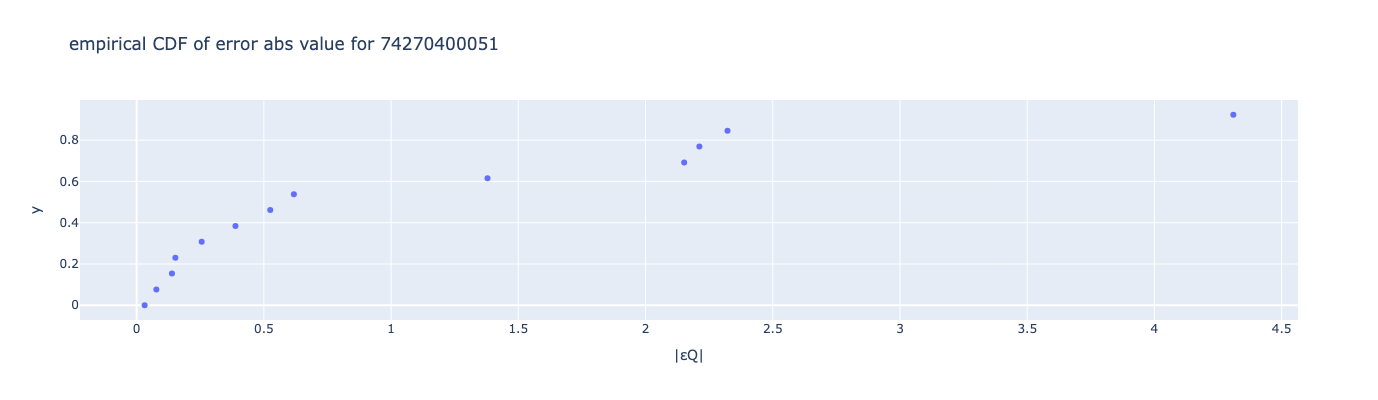

In [103]:
cdfplot(df['εQ'],reachid)

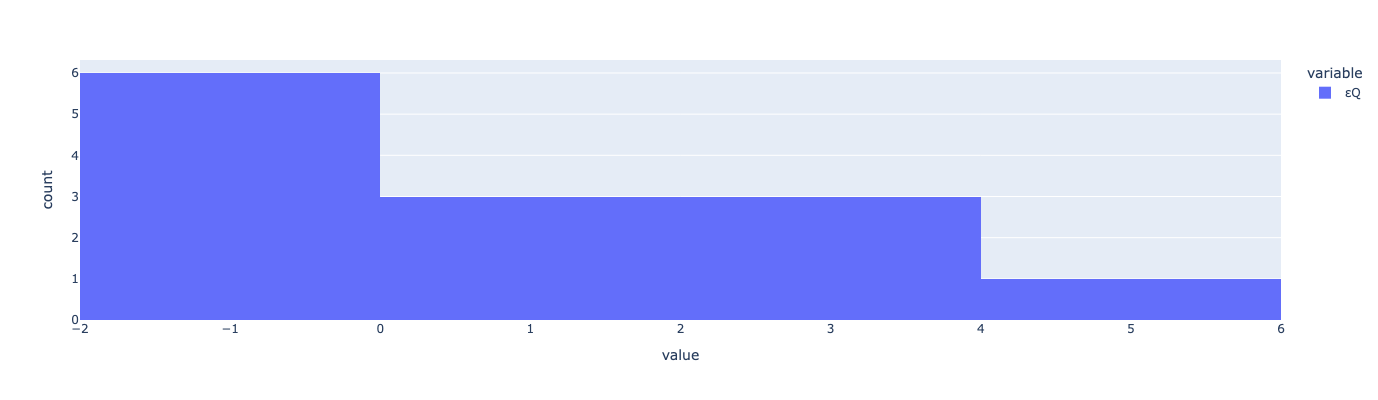

In [104]:
fig=px.histogram(df['εQ'],height=400,width=800)
fig.show()

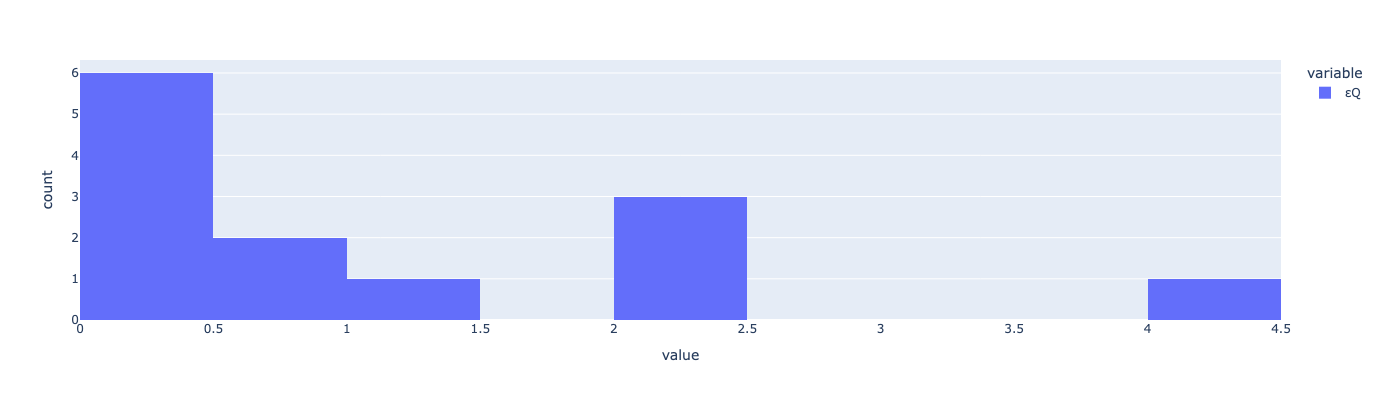

In [105]:
fig=px.histogram(df['εQ'].abs(),nbins=10,height=400,width=800)
fig.show()

## 5. Explore SWOT observation error

In [106]:
# gnssdf=pd.read_csv('offline_gnss_matched_wse_by_reach_id_river_name_20250213.csv')
# gnssdf[gnssdf['reach_id']==int(reachid)]

In [107]:
# # ptdf=pd.read_csv('pt_matched_wse_slp_by_reach_id_river_name_20250213.csv')
# ptdf=pd.read_csv('pt_matched_reach_wse_slp_by_reach_id_river_name-OBIT.csv')
# ptdf[ptdf['reach_id']==int(reachid)]

In [108]:
# dswxdf=pd.read_csv('width_rel_error_dswx_by_reach_id_river_name_20250213.csv')
# dswxdf[dswxdf['reach_id']==int(reachid)]

In [109]:
# printvars=['wse_rel_diff_cm_|68%ile|','slp_error_cmkm_|68%ile|']
# for printvar in printvars:
#     print(printvar,':',ptdf[ptdf['reach_id']==int(reachid)][printvar].values[0])

## 6. Look at calibrated FLPs, resistance, and try doing error propagation

In [110]:
dsr=dfps.loc[int(reachid)] # get dataseries for this reach
dsr

na             0.008704
A0            58.834035
x1             0.955842
RMSE          27.493521
rRMSE          1.671406
nRMSE          1.021118
NSE            0.424247
VE             0.343449
bias           1.949655
stdresid      27.424306
nbias          0.067521
MSC            0.357089
meanLogRes     0.308699
stdLogRes      0.791967
meanRelRes     0.848255
stdRelRes      1.440160
r              0.656450
KGE            0.423940
anr67          1.409885
nMAE           0.656551
Qbart         26.924924
n             13.000000
Name: 74270400051, dtype: float64

This FLP calibration used area = A0+dA, in MetroMan convention, with first index of dA=0 (thus A=A0 for first MetroMan time)

In [111]:
# # compute cross-sectional area, hydraulic depth and n
# df['A']=dsr['A0']+df['dA']
# df['D']=df['A']/df['w']
# df['n']=dsr['na']*df['D']**dsr['x1']

In [112]:
# fig = px.scatter(df, x='D', y='n')
# fig.show()

In [113]:
# max(df['n'])

In [114]:
# df['Qcheck']=1/df['n']*df['A']**(5/3)*df['w']**(-2/3)*(df['Scm/km']/1e5)**0.5
# # df
# max(abs(df['Qcheck']-df['Qhat']))

This verifies we've translated the flow law correctly

Following Durand et al RSE 2024 and Durand et al. WRR 2023:

$\left(\dfrac{\sigma_Q}{Q}\right)^2 = \overline{ \left( \dfrac{5}{3} \dfrac{\sigma_{dA}}{A_0+dA_t}    \right)^2  } 
    + \overline{ \left(\dfrac{2}{3} \dfrac{\sigma_W}{W_t} \right)^2   } 
    + \overline{ \left(\dfrac{1}{2} \dfrac{\sigma_S}{S_t} \right)^2   }   $
    
where the overline is an average. So you compute the average of the variance estimate at each time. 

You can approximate $\sigma_{dA}$ as $W \sigma_H \sqrt{2}$ following Durand et al. RSE 2020. I need to go pull out Rui's derivation which is actually in the discharge product. Better, just need to combine the power law on depth with the 5/3 exponent, and then it will include the affect of the resistance coefficient dependence on dA as well.

We are using:
    
$Q=\dfrac{1}{n} A^{5/3}W^{-2/3}S^{1/2} =  n D^{5/3}W S^{1/2}$

with $n=n_a D^{x_1}$

Combining:

$Q=\dfrac{1}{n_a} D^{x_1} D^{5/3}W S^{1/2} = n_a D^{5/3+x_1}W S^{1/2}$

So then you have: 

$Q=\dfrac{1}{n} A^{5/3+x_1} W^{-5/3-x_1}  WS^{1/2}=n_a A^{5/3+x_1} W^{-2/3-x_1} S^{1/2}$

And you should end up with:

$\left(\dfrac{\sigma_Q}{Q}\right)^2 = \overline{ \left( \left[ \dfrac{5}{3}+x_1 \right] \dfrac{\sigma_{dA}}{A_0+dA_t}    \right)^2  } 
    + \overline{ \left( \left[\dfrac{2}{3} + x_1 \right] \dfrac{\sigma_W}{W_t} \right)^2   } 
    + \overline{ \left(\dfrac{1}{2} \dfrac{\sigma_S}{S_t} \right)^2   }   $

So then $x_1$ could either increase or decrease sensitivity to error depending on whether it is positive or negative. If it's negative, as would be expected, it would decrease sensitivity.

In [115]:
# # pull out the width standard error
# if int(reachid) in list(dswxdf['reach_id']):    
#     σw_rel=dswxdf[dswxdf['reach_id']==int(reachid)]['width (rel. %)_|68%ile|'].values[0]/100
# else:
#     print('no width validation for this reach. setting to 25%')
#     σw_rel=0.25
# σw_rel

In [116]:
# # propagate width error to discharge error
# σ2Q_w_rel=(2/3*σw_rel)**2
# σ2Q_w_rel

In [117]:
# # pull out height standard error
# σH=ptdf[ptdf['reach_id']==int(reachid)]['wse_rel_diff_cm_|68%ile|'].values[0]/100 # cm->m
# σH

In [118]:
# # pull out slope standard error 
# σS=ptdf[ptdf['reach_id']==int(reachid)]['slp_error_cmkm_|68%ile|'].values[0]/1e5 #cm/km -> m/m
# σS

In [119]:
# # compute variance term for slope
# σ2Q_S_rel=np.mean((1/2*σS/(df['Scm/km']/1e5))**2)
# print('σQ for S:', np.sqrt(σ2Q_S_rel))

In [120]:
# σdA=σH*df['w'].mean()*np.sqrt(2)
# σdA

In [121]:
# # compute variance term for dA
# σ2Q_dA_rel=np.mean((5/3*σdA/df['A'])**2)
# print('σQ for dA:', np.sqrt(σ2Q_dA_rel))

In [122]:
# σQ_dA_rel=(5/3*σdA/df['A'].mean())
# print('σQ for dA:', σQ_dA_rel)

This term is probably an overestimate - I really ought to check this again. 

For now just use the relative width error. Could try to get fancier but probably unnecessary

In [123]:
# # compute total
# σQ_rel=np.sqrt(σ2Q_dA_rel+σ2Q_w_rel+σ2Q_S_rel)
# print('predicted performance for ',reachid,' is ',σQ_rel)

In [124]:
# # compute total
# σQ_rel=np.sqrt(σQ_dA_rel**2+σ2Q_w_rel+σ2Q_S_rel)
# print('predicted performance for ',reachid,' is ',σQ_rel)

## 7. Connect discharge performance to SWOT observations

In [125]:
#switch index to ones we can join on
# df=df.set_index('time_str')
# df.iloc[0:5]

In [126]:
# dfobs=dfobs.set_index('time')
# dfobs.iloc[0:5]

In [127]:
# merge the Q dataframe and the obs dataframe
# dfQo=pd.merge(df, dfobs,left_index=True,right_index=True)
# dfQo.iloc[0:5]

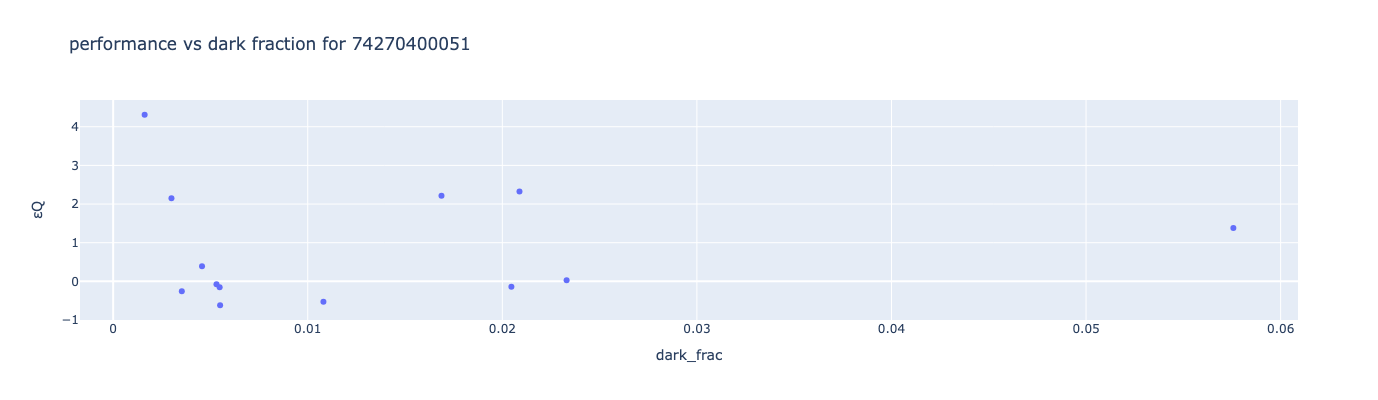

In [129]:
fig = px.scatter(df, x='dark_frac', y='εQ',title='performance vs dark fraction for '+reachid,height=400,width=800)
fig.show()

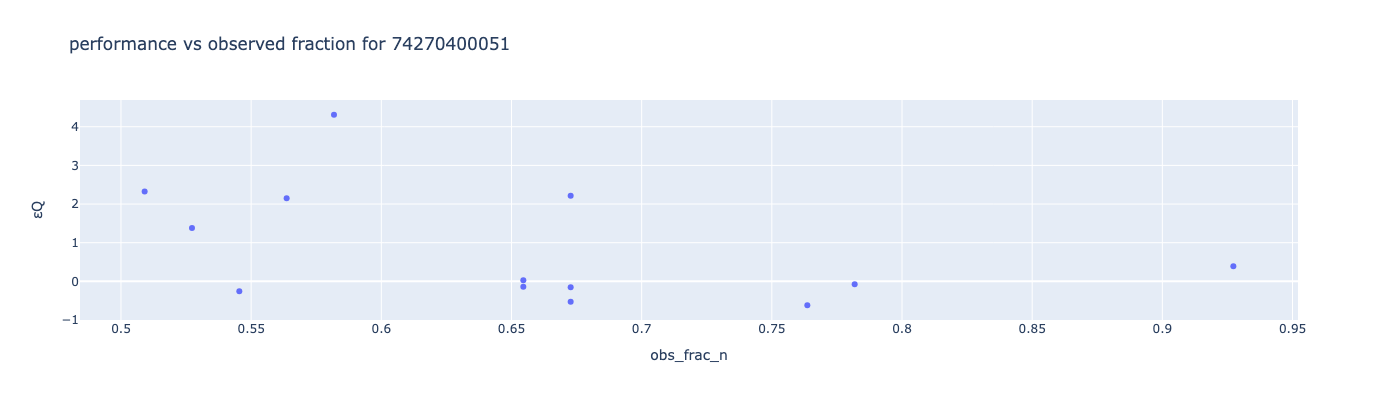

In [131]:
fig = px.scatter(df, x='obs_frac_n', y='εQ',title='performance vs observed fraction for '+reachid,height=400,width=800)
fig.show()

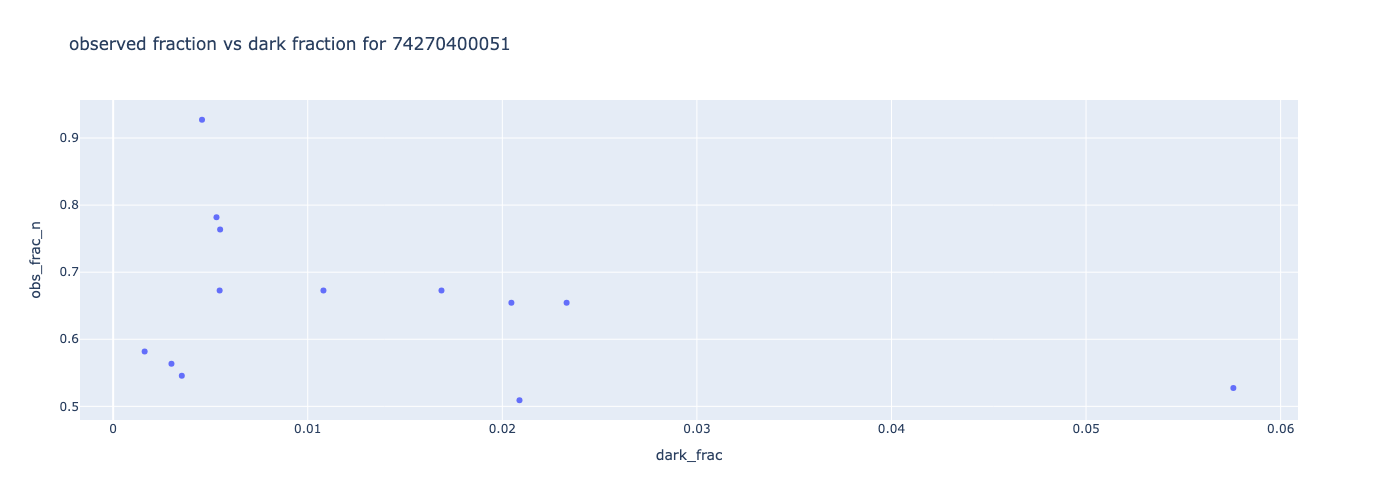

In [132]:
fig = px.scatter(df, x='dark_frac', y='obs_frac_n',title='observed fraction vs dark fraction for '+reachid,
                height=500,
                width=500)
fig.show()

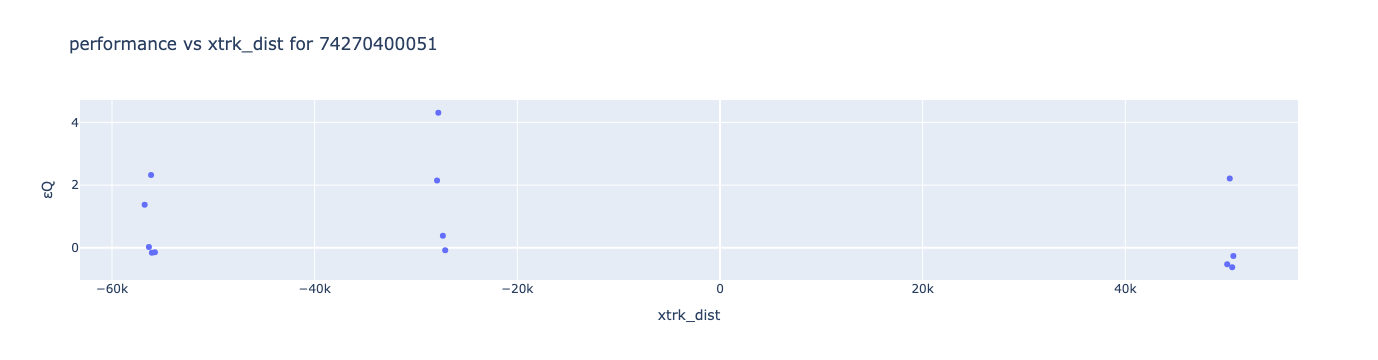

In [133]:
fig = px.scatter(df, x='xtrk_dist', y='εQ',title='performance vs xtrk_dist for '+reachid)
fig.show()

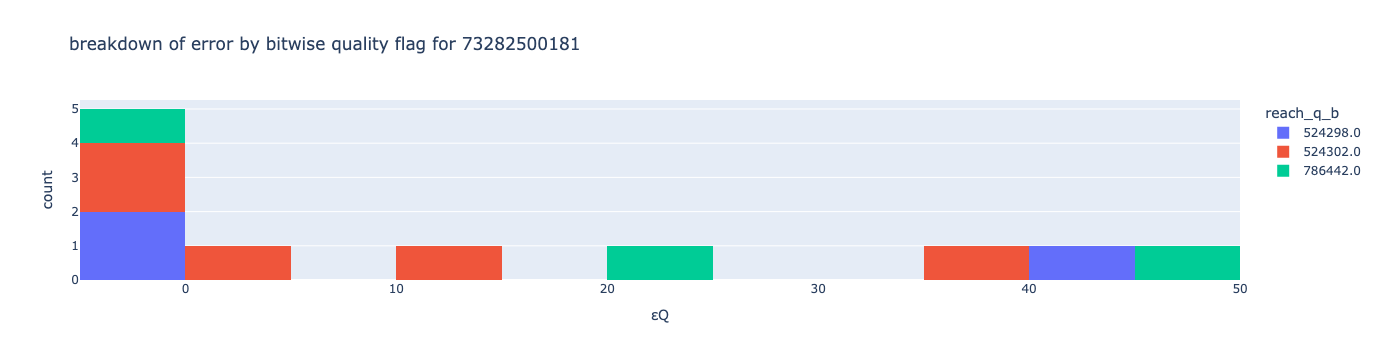

In [66]:
# fig=px.histogram(dfQo[dfQo['reach_q_b']==524302]['εQ'])
fig=px.histogram(df,x='εQ',color='reach_q_b',nbins=20
                 ,title='breakdown of error by bitwise quality flag for '+reachid)
fig.show()

In [67]:
unique_flags=list(set(list(df['reach_q_b'])))
unique_flags=[int(flag) for flag in unique_flags]
print('unique bitwise quality flags:',unique_flags)

unique bitwise quality flags: [524298, 786442, 524302]


In [68]:
for flag in unique_flags:
    print('for flag =',flag)
    check_classification(flag,flag_data)

for flag = 524298
    data point has classification_qual_suspect set to True
    data point has water_fraction_suspect set to True
    data point has geolocation_qual_degraded set to True
for flag = 786442
    data point has classification_qual_suspect set to True
    data point has water_fraction_suspect set to True
    data point has classification_qual_degraded set to True
    data point has geolocation_qual_degraded set to True
for flag = 524302
    data point has classification_qual_suspect set to True
    data point has geolocation_qual_suspect set to True
    data point has water_fraction_suspect set to True
    data point has geolocation_qual_degraded set to True


In [69]:
flag_count=[]
for flag in unique_flags:
    flag_count.append(sum(df['reach_q_b']==flag))
    
pd.DataFrame( data={'flag':unique_flags, 'count': flag_count} )

,flag,count
0,524298,3
1,786442,3
2,524302,5


# Results

Compiled these by running notebook on one reach at a time and making observations. These are all connected to the power law resistance formulation.

### Wilamette
* 78220000201 on the Willamette river 
    * meets all sciecne requirements except river width. The 68th percentile of the discharge error is 14%. 
    * Confluence sets slope set to a constant value for this reach. 
    * Would be nice to verify this via error propagation but discharge error vs predicted uncertainty should be correct
    * Resistance drops at low flow, which it should not do. So here it must be that the power law resistance is compensationg for something.
    * there's a bit of a bias for cycles when geolocation is set to degraded
    * observed fraction all above 80%
* 78220000211 on the Willamette river
    * fairly poor WSE and width performance, due to bright fields sometimes being attached to the river
    * from PTs, wse error is 43 cm and slope error is 2 cm/k  (both n=77) 
    * width error 31% (but n=5)
    * discharge error is just 14%, but uncertainty propagation would predict more like 40%. 
    * the degraded geolocation quality flag does explain some of the higher errors. performance is often ok when quality is degraded, but most of the poor quality points are degraded
    * Hypothesis: the Tukey filter tosses outliers and the remaining WSE and slope error are more reasonable. 
* 78220000221 on the Willamette river
    * briefly: discharge performance is good (11%), but WSE error says accuracy is only 21.6 cm. how can this be? should I be subtracting WSE bias, since this does not hurt discharge error statistics?
    * geolocation degraded explains some of the largest Q fit errors
* 78220000231 on the Willamette river
    * briefly: discharge performance is good (15%), but WSE error says accuracy is only 51 cm. how can this be? should I be subtracting WSE bias, since this does not hurt discharge error statistics?
    * geolocation degraded explains some of the largest Q fit errors

### Connecticut

* 73120000081 on the Connecticut river
    * briefly: weird. all slopes set to zero by Confluence, so calibration did not run at all. that should never happen. Need to revisit this. Cassie says that it performs well in WSE, but all error is like 3 m. 
    * Need input on interpreting bias
* 73120000091 on the Connecticut river
    * briefly: performance is very poor. presumably cassie's note that this reach meetgs requirements is a typo
    * super weird too - all slopes set to almost zero
    * WSE error is 59 cm, and discharge error is 59%, so error propagatino should work fine here
    * fit is very poor: it uses a very low resistance coefficient and a huge river depth (20 m)
    * data quality flags do not seem to explain much of the error
* 73120000111 on the Connecticut river
    * discharge error is strongly correlated with WSE error. presumably, this means WSE error is decreasing at low flow though could be other factors
    * WSE performance is good (9 cm) but discharge performance is poor (40%). 
    * width is generally invariant so error should not be due to width
    * Note that we should use instantaneous discharge error on the Connecticut.
    * hypothesis: slope changes at low flow, but Confluence sets these to constant, degrading low flow performance. could check by looking at height vs slope from hydrochron
    * performance is somewhat worse when observed fraction is less than 0.8
    * hypothesis: aliasing occurs at low flow with hydropeaking dam operations. could check by pulling instantaneous discharge
* 73120000121 on the Connecticut river 
    * second worst reach in the cal-val set. 
    * from PTs, The 68th percentile of the WSE error is 183 cm (n=55) and slope error is 24 cm/km (n=23). 
    * Width error unknown as n=1.  
    * SWOT height vs SWOT width is uncorrelated, but SWOT width is basically invariant. 
    * clear relationship between SWOT height and gage Q, with some issues of erroneously high WSE for some low values of gage Q
    * Discharge error at 68th percentile is only 24%. The uncertainty propagation would estimate over 100% error. 
    * Hypothesis: the Tukey filter tosses outliers and the remaining WSE and slope error are more reasonable. 
    * Note that we should use instantaneous discharge error on the Connecticut.
    * Errors are worse when:
        * geolocation quality flag is set to degraded
        * observed fraction is less than 0.8
        * dark fraction is greater than 0.3
* 73120000131 on the Connecticut river 
    * worst reach in the cal-val set. 
    * from PTs, The 68th percentile of the WSE error is 45 cm (n=41) and slope error is 8 cm/km (n=36). 
    * width error unknown
    * clear relationship between SWOT height and gage Q, with some issues of erroneously high WSE for some low values of gage Q
    * SWOT height vs SWOT width is negatively correlated, but SWOT width is basically invariant. 
    * Discharge error at 68th percentile is 41%. The uncertainty propagation is expected to be accurate
    * Resistance drops at low flow, which it should not do. So here it must be that the power law resistance is compensationg for 
    * In general, data quality does not do much to explain the error
    * Note that we should use instantaneous discharge error on the Connecticut.


## Questions
* How best to interpret the 68th percentile of error, in the case when there's a strong bias such as 78220000221? Is the 68th percentile statistic calculated over relative changes in WSE?
* How best to reconcile filters between what Cassie does and what Confluence does? If I send Cassie the filter we're using can she send back error statistics?
* Why are all slopes set to zero for 73120000081 by Confluence? Need to investigate this
* Would it matter if I turned on the height-width constraint? I think if it is set correctly, it should basically set widths to a constant, which would remove a small source of noise, but should otherwise not make a huge difference. 
* Would it matter if I used the height-width fit with constrained height and width to calculate cross-sectional area, for the poor performers? I suspect not.
* What would the impact of using instantaneous discharge be?
* What's the correct way to do the error propagation for the power law n?


## Digging
* I looked at whether it mattered if I intialize the power law exponent in various ways and it really doesn't: even if I start it at a value of -1, it really finds it more optimal to be a positive number. 
* I looked briefly to compare two reaches between power law n and constant n, and saw just very small changes between them. nothing like the differences among reaches

## To look into but maybe not top priority
* It is interesting whether any of the other flow laws might do any better, which would be pretty easy to check; just use the ArcticDEM notebook setup. Should at least check on the constant n
